In [1]:
from __future__ import division
import os
import logging
import time
import glob
import datetime
import argparse
import numpy as np
from scipy.io import loadmat, savemat
from sklearn.feature_extraction import image
from glob import glob

import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from arch_unet import UNet
import utils as util
from collections import OrderedDict
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

from Sber_utils import Masker, save_network, load_network, save_state, resume_state, checkpoint, generate_mask, interpolate_mask, depth_to_space, get_generator

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--noisetype", type=str, default="gauss25", choices=['gauss25', 'gauss5_50', 'poisson30', 'poisson5_50'])
parser.add_argument('--resume', type=str)
parser.add_argument('--checkpoint', type=str)
parser.add_argument('--train_dir', type=str, default='./dataset/small/train')
parser.add_argument('--test_dir', type=str, default='./dataset/small/validation')
parser.add_argument('--save_test_path', type=str, default='./test')
parser.add_argument('--save_model_path', type=str, default='../experiments/small')
parser.add_argument('--log_name', type=str, default='xxx_b2u_unet_fmdd_112rf20')
parser.add_argument('--gpu_devices', default='0', type=str)
parser.add_argument('--parallel', action='store_true')
parser.add_argument('--n_feature', type=int, default=48)
parser.add_argument('--n_channel', type=int, default=1)
parser.add_argument('--lr', type=float, default=1e-4)
parser.add_argument('--w_decay', type=float, default=1e-8)
parser.add_argument('--gamma', type=float, default=0.5)
parser.add_argument('--n_epoch', type=int, default=100)
parser.add_argument('--n_snapshot', type=int, default=1)
parser.add_argument('--batchsize', type=int, default=4)
parser.add_argument('--patchsize', type=int, default=128)
parser.add_argument("--Lambda1", type=float, default=1.0)
parser.add_argument("--Lambda2", type=float, default=2.0)
parser.add_argument("--increase_ratio", type=float, default=20.0)
parser.add_argument('--test_dataset_name', type=str)
parser.add_argument('--train_dataset_name', type=str)
parser.add_argument('--repeat_times', type=int, default=3)



opt = parser.parse_args([
                        '--train_dir', './data/train', 
                        '--test_dir', './data/test',
                        '--save_test_path', './test',
                        '--save_model_path', './experiments/my_models', 
                        '--log_name', 'b2u_g146_first',
                        '--test_dataset_name', 'validation_g146',
                        '--train_dataset_name', 'G146_first',
                        '--Lambda1', '1.0',
                        '--Lambda2', '2.0',
                        '--increase_ratio', '20.0',
                        '--n_epoch', '100',
                        '--batchsize', '2'
                        ])
                        
systime = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
operation_seed_counter = 0
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpu_devices
torch.set_num_threads(8)

opt.save_path = os.path.join(opt.save_model_path, opt.log_name)
os.makedirs(opt.save_path, exist_ok=True)
os.makedirs('./metrics/', exist_ok=True)

# imgs_dir = os.path.join()
# os.makedirs(os.path.join('./metrics/', opt.train_dataset_name + '/'), exist_ok=True)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [ ]:
def make_validation(imgs_dir, val_dir, max_len_val, patch_size, max_patches, random_state=42):
    imgs = sorted(os.listdir('./data/train/G146_first/'))
    imgs_patches = []
    
    for img in imgs:
        img_ = cv2.imread('./data/train/G146_first/' + img, 0)
        patchesimgs = image.extract_patches_2d(img_, patch_size=patch_size, max_patches=max_patches, random_state=random_state)
        
        for j in range(patchesimgs.shape[0]):
            imgs_patches.append(patchesimgs[j])
    ind_val = random.sample(range(len(imgs_patches)), max_len_val)

    X_val = [imgs_patches[i] for i in ind_val]

    count = 0
    for j in range(0, len(X_val)):
        cv2.imwrite('./data/test/validation_g146/' + str(count).zfill(4)+'.tif', X_val[j])
        count += 1

make_validation(os.path.join(opt.train_dir, '/' + opt.train_dataset_name), os.path.join(opt.test_dir, '/' + opt.test_dataset_name), 30, (512, 512), 100, random_state=42)

In [3]:
def ssim(prediction, target):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2
    img1 = prediction.astype(np.float64)
    img2 = target.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())
    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2
    ssim_map = ((2 * mu1_mu2 + C1) *
                (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                       (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(target, ref):
    '''
    calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    img1 = np.array(target, dtype=np.float64)
    img2 = np.array(ref, dtype=np.float64)
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1[:, :, i], img2[:, :, i]))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')


def calculate_psnr(target, ref, data_range=255.0):
    img1 = np.array(target, dtype=np.float32)
    img2 = np.array(ref, dtype=np.float32)
    diff = img1 - img2
    psnr = 10.0 * np.log10(data_range**2 / np.mean(np.square(diff)))
    return psnr

In [4]:
def write_in_file(metrics, name_metric, name_dataset):
    with open(f"./metrics/{name_metric}_{name_dataset}.txt", "w") as file:
        for metric in metrics:
            file.write(str(metric) + '\n')       

In [5]:
def apply_median(img, percentile):
    tresh = np.percentile(img.ravel(), percentile)
    mask = np.zeros_like(img)
    mask[img < tresh] = 1
    median_img = cv2.medianBlur(img, 7)
    img = img*(1 - mask) + median_img * mask
    return img

In [6]:
class TestMicroscopyDataset(Dataset):
    def __init__(self, img_dir,channels=3, transform=None, apply_median=False):
        self.img_dir = img_dir
        self.apply_median = apply_median
        self.transform = transform
        self.img_filenames = os.listdir(img_dir)
        if channels == 1:
            self.channels = 0
        else:
            self.channels = channels

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        name = os.path.split(self.img_filenames[idx])[-1].split('.')[0]

        image = cv2.imread(os.path.join(self.img_dir, self.img_filenames[idx]), self.channels)


        if self.apply_median:
            image = apply_median(image, 10)

        if self.transform:
            image = self.transform(image)

        return image, name

In [7]:
class TrainMicroscopyDataset(Dataset):
    def __init__(self, img_dir,channels=3, transform=None, patch=256, apply_median=False):
        self.img_dir = img_dir
        self.apply_median = apply_median
        self.transform = transform
        self.img_filenames = os.listdir(img_dir)
        if channels == 1:
            self.channels = 0
        else:
            self.channels = channels

        self.patch = patch
        print('fetch {} samples for training'.format(len(self.img_filenames)))

    def __getitem__(self, idx):
        # fetch image
        name = os.path.split(self.img_filenames[idx])[-1].split('.')[0]

        image = cv2.imread(os.path.join(self.img_dir, self.img_filenames[idx]), self.channels)
        # random crop
        if len(image.shape) == 2:
            H = image.shape[0]
            W = image.shape[1]

        CSize = self.patch
        rnd_h = np.random.randint(0, max(0, H - CSize))
        rnd_w = np.random.randint(0, max(0, W - CSize))
        image = image[rnd_h : rnd_h + CSize, rnd_w : rnd_w + CSize]


        if self.apply_median:
            image = apply_median(image, 10)

        if self.transform:
            image = self.transform(image)

        return image, name

    def __len__(self):
        return len(self.img_filenames)

In [8]:
# Dataset
train_transforms = transforms.Compose([transforms.ToTensor()])
train_dataset_dir = os.path.join(opt.train_dir, opt.train_dataset_name)
train_dataset = TrainMicroscopyDataset(train_dataset_dir,opt.n_channel, transform=train_transforms, apply_median=False)
train_dataloader = DataLoader(dataset=train_dataset, num_workers=8, batch_size=opt.batchsize, shuffle=True)

test_transforms = transforms.Compose([transforms.ToTensor()])
test_dataset_dir = os.path.join(opt.test_dir, opt.test_dataset_name)
test_dataset = TestMicroscopyDataset(test_dataset_dir,opt.n_channel, transform=test_transforms, apply_median=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Masker
masker = Masker(width=4, mode='interpolate', mask_type='all')
# Network
network = UNet(in_channels=opt.n_channel,
                out_channels=opt.n_channel,
                wf=opt.n_feature)
if opt.parallel:
    network = torch.nn.DataParallel(network)
network = network.cuda()

# validation
save_test_path = os.path.join(opt.save_test_path, opt.test_dataset_name)
os.makedirs(save_test_path, exist_ok=True)

validation_path = os.path.join(save_test_path, opt.log_name)
os.makedirs(validation_path, exist_ok=True)
# np.random.seed(101)

# about training scheme
num_epoch = opt.n_epoch
ratio = num_epoch / 100
optimizer = optim.Adam(network.parameters(), lr=opt.lr,
                       weight_decay=opt.w_decay)
scheduler = lr_scheduler.MultiStepLR(optimizer,
                                     milestones=[
                                         int(20 * ratio) - 1,
                                         int(40 * ratio) - 1,
                                         int(60 * ratio) - 1,
                                         int(80 * ratio) - 1
                                     ],
                                     gamma=opt.gamma)
print("Batchsize={}, number of epoch={}".format(opt.batchsize, opt.n_epoch))

# Resume and load pre-trained model
epoch_init = 1
if opt.resume is not None:
    epoch_init, optimizer, scheduler = resume_state(opt.resume, optimizer, scheduler)
if opt.checkpoint is not None:
    network = load_network(opt.checkpoint, network, strict=True)

# temp
if opt.checkpoint is not None:
    epoch_init = 65
    for i in range(1, epoch_init):
        scheduler.step()
        new_lr = scheduler.get_lr()[0]
        logger.info('----------------------------------------------------')
        logger.info("==> Resuming Training with learning rate:{}".format(new_lr))
        logger.info('----------------------------------------------------')

print('init finish')


Thread1 = 0.4
Thread2 = 1.0
Lambda1 = opt.Lambda1
Lambda2 = opt.Lambda2
increase_ratio = opt.increase_ratio


fetch 321 samples for training
Batchsize=2, number of epoch=100
init finish


LearningRate of Epoch 1 = 0.0001


100%|██████████| 161/161 [01:41<00:00,  1.59it/s]


LearningRate of Epoch 2 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 3 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 4 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 5 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 6 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 7 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 8 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 9 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 10 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 11 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 12 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 13 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 14 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 15 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 16 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 17 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 18 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 19 = 0.0001


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 20 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 21 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 22 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 23 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 24 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 25 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 26 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 27 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 28 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 29 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 30 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 31 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 32 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 33 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 34 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 35 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 36 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 37 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 38 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 39 = 5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 40 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 41 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 42 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 43 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 44 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 45 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 46 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 47 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 48 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 49 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 50 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 51 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 52 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 53 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 54 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 55 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 56 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 57 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 58 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 59 = 2.5e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 60 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 61 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 62 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 63 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 64 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 65 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 66 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 67 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 68 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 69 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 70 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 71 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 72 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 73 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 74 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 75 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 76 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 77 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 78 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 79 = 1.25e-05


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 80 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 81 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 82 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 83 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 84 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 85 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 86 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 87 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 88 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 89 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 90 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 91 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 92 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 93 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 94 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 95 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 96 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 97 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 98 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 99 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


LearningRate of Epoch 100 = 6.25e-06


100%|██████████| 161/161 [01:40<00:00,  1.60it/s]


average psnr for val: 16.097894425028173
average ssim for val: 0.13509178911220016


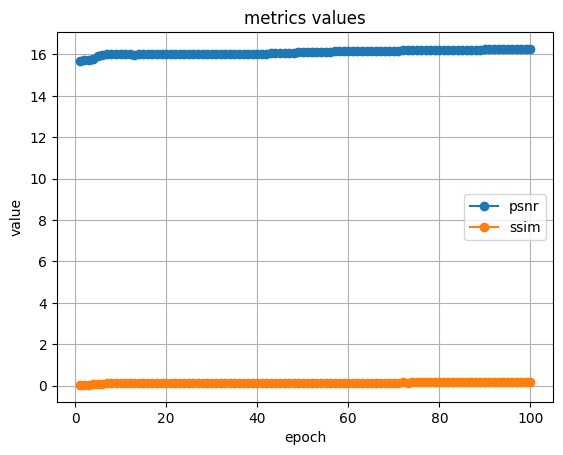

In [9]:
# epoch_psnr = []
# epoch_ssim = []

# epoch_exp_psnr = []
# epoch_exp_ssim = []

epoch_val_psnr = []
epoch_val_ssim = []

for epoch in range(epoch_init, opt.n_epoch + 1):
    cnt = 0

    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
    print("LearningRate of Epoch {} = {}".format(epoch, current_lr))

    network.train()

    # img_psnr = []
    # img_ssim = []

    # img_exp_psnr = []
    # img_exp_ssim = []
    for noisy, name in tqdm(train_dataloader):

        st = time.time()
        # noisy = noisy / 255.0
        # print(noisy.shape)

        noisy = noisy.cuda()
        # print('noisy_mean', noisy.mean())

        optimizer.zero_grad()

        net_input, mask = masker.train(noisy)
        noisy_output = network(net_input)
        n, c, h, w = noisy.shape
        noisy_output = (noisy_output*mask).view(n, -1, c, h, w).sum(dim=1)
        diff = noisy_output - noisy

        # psnr and ssim for one image
        # target = torch.unsqueeze(noisy, 0).permute(0, 2, 3, 1).cpu().data.clamp(0, 1).numpy().squeeze(0).astype(np.float32)
        # ref = diff.permute(0, 2, 3, 1).cpu().data.clamp(0, 1).numpy().squeeze(0).astype(np.float32)
        # img_psnr.append(calculate_psnr(target, ref))
        # img_ssim.append(calculate_ssim(target, ref))



        with torch.no_grad():
            exp_output = network(noisy)
        exp_diff = exp_output - noisy

        # psnr and ssim for exp
        # ref_exp = exp_diff.permute(0, 2, 3, 1).cpu().data.clamp(0, 1).numpy().squeeze(0).astype(np.float32)
        # img_exp_psnr.append(calculate_psnr(target, ref_exp))
        # img_exp_ssim.append(calculate_ssim(target, ref_exp))

        # g25, p30: 1_1-2; frange-10
        # g5-50 | p5-50 | raw; 1_1-2; range-10
        Lambda = epoch / opt.n_epoch
        if Lambda <= Thread1:
            beta = Lambda2
        elif Thread1 <= Lambda <= Thread2:
            beta = Lambda2 + (Lambda - Thread1) * \
                (increase_ratio-Lambda2) / (Thread2-Thread1)
        else:
            beta = increase_ratio
        alpha = Lambda1

        revisible = diff + beta * exp_diff
        loss_reg = alpha * torch.mean(diff**2)
        loss_rev = torch.mean(revisible**2)
        loss_all = loss_reg + loss_rev

        loss_all.backward()
        optimizer.step()



    # epoch_psnr.append(np.mean(img_psnr))
    # epoch_ssim.append(np.mean(img_ssim))

    # epoch_exp_psnr.append(np.mean(img_exp_psnr))
    # epoch_exp_ssim.append(np.mean(img_exp_ssim))
        
    scheduler.step()

    if epoch % opt.n_snapshot == 0 or epoch == opt.n_epoch:
        network.eval()
        # save checkpoint
        save_network(network, epoch, "model", opt=opt)
        save_state(epoch, optimizer, scheduler, opt=opt)

        # validation
        np.random.seed(101)

        save_dir = os.path.join(validation_path, f'epoch_{epoch}')
        os.makedirs(save_dir, exist_ok=True)


        # for idx in range(num_img):
        for im, name in test_dataloader:
            img_avg_psnr_mid = []
            img_avg_ssim_mid = []
            
            if type(im) == torch.Tensor:
                if len(im.shape) == 4: 
                    im = im.squeeze(0)
                im = im.permute(1,2,0)
                im = im.numpy()
            origin255 = im.copy() * 255
            origin255 = origin255.astype(np.uint8)
            im = np.array(im, dtype=np.float32) #/ 255.0
            noisy_im = im.copy() # add
            noisy255 = noisy_im.copy()
            noisy255 = np.clip(noisy255 * 255.0 + 0.5, 0,
                                255).astype(np.uint8)

            # padding to square
            H = noisy_im.shape[0]
            W = noisy_im.shape[1]
            val_size = (max(H, W) + 31) // 32 * 32
            noisy_im = np.pad(
                noisy_im,
                [[0, val_size - H], [0, val_size - W], [0, 0]],
                'reflect')
            transformer = transforms.Compose([transforms.ToTensor()])
            noisy_im = transformer(noisy_im)
            noisy_im = torch.unsqueeze(noisy_im, 0)
            noisy_im = noisy_im.cuda()
            with torch.no_grad():
                n, c, h, w = noisy_im.shape
                net_input, mask = masker.train(noisy_im)
                noisy_output = (network(net_input) *
                                mask).view(n, -1, c, h, w).sum(dim=1)
                dn_output = noisy_output.detach().clone()
                # Release gpu memory
                del net_input, mask, noisy_output
                torch.cuda.empty_cache()
                exp_output = network(noisy_im)
            pred_dn = dn_output[:, :, :H, :W]
            pred_exp = exp_output.detach().clone()[:, :, :H, :W]
            # print('pred_exp mean', pred_exp.mean())
            pred_mid = (pred_dn + beta*pred_exp) / (1 + beta)

            # Release gpu memory
            del exp_output
            torch.cuda.empty_cache()

            pred_dn = pred_dn.permute(0, 2, 3, 1)
            pred_exp = pred_exp.permute(0, 2, 3, 1)
            pred_mid = pred_mid.permute(0, 2, 3, 1)

            pred_dn = pred_dn.cpu().data.clamp(0, 1).numpy().squeeze(0)
            pred_exp = pred_exp.cpu().data.clamp(0, 1).numpy().squeeze(0)
            pred_mid = pred_mid.cpu().data.clamp(0, 1).numpy().squeeze(0)

            pred255_dn = np.clip(pred_dn * 255.0 + 0.5, 0,
                                    255).astype(np.uint8)
            pred255_exp = np.clip(pred_exp * 255.0 + 0.5, 0,
                                    255).astype(np.uint8)
            pred255_mid = np.clip(pred_mid * 255.0 + 0.5, 0,
                                    255).astype(np.uint8)



            # calculate psnr and ssim for val dataset
            psnr_mid = calculate_psnr(origin255.astype(np.float32),
                                        pred255_mid.astype(np.float32))
            img_avg_psnr_mid.append(psnr_mid)
            ssim_mid = calculate_ssim(origin255.astype(np.float32),
                                        pred255_mid.astype(np.float32))
            img_avg_ssim_mid.append(ssim_mid)


            # visualization
            if opt.n_channel == 1:
                color_mode = 'L'
                save_path = os.path.join(save_dir, f"{name}_clean.png")
                Image.fromarray(origin255.squeeze()).convert(color_mode).save(save_path)

                save_path = os.path.join(save_dir, f"{name}_noisy.png")    
                Image.fromarray(noisy255.squeeze()).convert(color_mode).save(save_path)

                save_path = os.path.join(save_dir, f"{name}_dn.png") 
                Image.fromarray(pred255_dn.squeeze()).convert(color_mode).save(save_path)

                save_path = os.path.join(save_dir, f"{name}_exp.png") 
                Image.fromarray(pred255_exp.squeeze()).convert(color_mode).save(save_path)

                save_path = os.path.join(save_dir, f"{name}_mid.png") 
                Image.fromarray(pred255_mid.squeeze()).convert(color_mode).save(save_path)
            else:
                color_mode = 'L'
                save_path = os.path.join(save_dir, f"{name}_clean.png")
                Image.fromarray(origin255).convert(color_mode).save(save_path)

                save_path = os.path.join(save_dir, f"{name}_noisy.png")    
                Image.fromarray(noisy255).convert(color_mode).save(save_path)

                save_path = os.path.join(save_dir, f"{name}_dn.png") 
                Image.fromarray(pred255_dn).convert(color_mode).save(save_path)

                save_path = os.path.join(save_dir, f"{name}_exp.png") 
                Image.fromarray(pred255_exp).convert(color_mode).save(save_path)

                save_path = os.path.join(save_dir, f"{name}-_mid.png") 
                Image.fromarray(pred255_mid).convert(color_mode).save(save_path)

        epoch_val_psnr.append(np.mean(img_avg_psnr_mid))
        epoch_val_ssim.append(np.mean(img_avg_ssim_mid))
            

# psnr = np.mean(epoch_psnr)
# ssim = np.mean(epoch_ssim)
# psnr_exp = np.mean(epoch_exp_psnr)
# ssim_exp = np.mean(epoch_exp_ssim)

# print(f'average psnr: {psnr}\n average ssim: {ssim}\naverage exp psnr: {exp_psnr}\naverage exp ssim: {exp_ssim}\n')
    
print(f'average psnr for val: {np.mean(epoch_val_psnr)}\naverage ssim for val: {np.mean(epoch_val_ssim)}')
write_in_file(epoch_val_ssim, 'ssim', opt.train_dataset_name)
write_in_file(epoch_val_psnr, 'psnr', opt.train_dataset_name)


plt.plot(np.arange(1, len(epoch_val_psnr) + 1), epoch_val_psnr, marker='o', linestyle='-', label='psnr')
plt.plot(np.arange(1, len(epoch_val_ssim) + 1), epoch_val_ssim, marker='o', linestyle='-', label='ssim')
plt.xlabel('epoch')
plt.ylabel('value')
plt.title('metrics values')
plt.grid()
plt.legend()


plt.savefig(f'./figs/psnr and ssim for {opt.train_dataset_name}.png')
plt.show()


In [10]:
torch.cuda.empty_cache()

In [11]:
parser = argparse.ArgumentParser()
parser.add_argument("--noisetype", type=str, default="gauss25", choices=['gauss25', 'gauss5_50', 'poisson30', 'poisson5_50'])
parser.add_argument('--checkpoint', type=str, default='./*.pth')
parser.add_argument('--test_dir', type=str, default='./data/test')
parser.add_argument('--save_test_path', type=str, default='./test')
parser.add_argument('--log_name', type=str, default='b2u_unet_g25_112rf20')
parser.add_argument('--gpu_devices', default='0', type=str)
parser.add_argument('--parallel', action='store_true')
parser.add_argument('--n_feature', type=int, default=48)
parser.add_argument('--n_channel', type=int, default=1)
parser.add_argument("--beta", type=float, default=20.0)
parser.add_argument('--dataset_name', type=str)
parser.add_argument('--repeat_times', type=int, default=1)
parser.add_argument('--_continue', type=bool, default=True)

opt = parser.parse_args(['--noisetype', 'gauss5_50', 
                        # '--checkpoint', './pretrained_models/g5-50_112rf20_beta19.4.pth',
                        # '--checkpoint', './experiments/my_models/b2u_second/models/epoch_model_100.pth',
                        '--checkpoint', './experiments/my_models/b2u_g146_first/models/epoch_model_100.pth',
                        '--test_dir', './data/train',
                        '--save_test_path', './test',
                        '--log_name', 'b2u_g146_first',
                        '--beta', '19.4',
                        '--dataset_name', 'G146_first'])
                        
systime = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
operation_seed_counter = 0
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpu_devices
torch.set_num_threads(8)

In [12]:
class Image_cropping():
    def __init__(self, img_size, crop_size, margin) -> None:
        self.margin = margin
        self.img_size = img_size
        self.stride_v = crop_size[0] - margin
        self.stride_h = crop_size[1] - margin
        self.crop_size = crop_size
        self.h_steps = int(np.ceil(img_size[1]/self.stride_h))
        self.v_steps = int(np.ceil(img_size[0]/self.stride_v))
        self.crop_nums = self.h_steps * self.v_steps

    def get_position(self, index):
        v_step = int(np.floor(index/self.v_steps))
        h_step = index - (v_step*self.v_steps)

        return v_step, h_step
    
    
    def crop_image(self, img, index):
        v_step, h_step = self.get_position(index)

        return img[v_step*self.stride_v : v_step*self.stride_v + self.crop_size[0],
                                     h_step*self.stride_h : h_step*self.stride_h + self.crop_size[1]]
    
    def concat(self, img_array):
        img = np.empty(self.img_size)
        i = 0
        for v in range(self.v_steps):
            for h in range(self.h_steps):
                flag_v = 1
                flag_h = 1

                if v == 0:
                    flag_v = 0
                if h == 0:
                    flag_h = 0

                
                img[v*self.stride_v + flag_v * (self.margin//2): v*self.stride_v + self.crop_size[0],
                                     h*self.stride_h + flag_h * (self.margin//2):h*self.stride_h + self.crop_size[1]] = img_array[i] [flag_v * (self.margin//2):, flag_h * (self.margin//2):]


                i+=1

        return img

In [13]:
def apply_median(img, percentile):
    tresh = np.percentile(img.ravel(), percentile)
    mask = np.zeros_like(img)
    mask[img < tresh] = 1
    median_img = cv2.medianBlur(img, 7)
    img = img*(1 - mask) + median_img * mask
    return img

In [14]:
class MicroscopyDataset(Dataset):
    def __init__(self, img_dir, cropping, channels=3, transform=None, apply_median=False):
        self.cropping_object = cropping
        self.img_dir = img_dir
        self.transform = transform
        self.crop_nums = cropping.crop_nums
        self.img_filenames = os.listdir(img_dir)
        self.apply_median = apply_median
        if channels == 1:
            self.channels = 0
        else:
            self.channels = channels

    def __len__(self):
        return (len(self.img_filenames) * self.crop_nums)

    def __getitem__(self, crop_idx):
        image_idx = crop_idx // self.crop_nums
        img_crop_idx = crop_idx % self.crop_nums
        # print(f'img index {image_idx}, img_crop_idx {img_crop_idx}')
        name = os.path.split(self.img_filenames[image_idx])[-1].split('.')[0]

        image = cv2.imread(os.path.join(self.img_dir, self.img_filenames[image_idx]), self.channels)

        crop = self.cropping_object.crop_image(image, img_crop_idx)

        if self.apply_median:
            crop = apply_median(crop, 10)
        

        if self.transform:
            crop = self.transform(crop)

        return crop, name

In [15]:
# validation
save_test_path = os.path.join(opt.save_test_path, opt.dataset_name)
os.makedirs(save_test_path, exist_ok=True)

validation_path = os.path.join(save_test_path, opt.log_name)
os.makedirs(validation_path, exist_ok=True)
np.random.seed(101)


# Dataset
test_transforms = transforms.Compose([transforms.ToTensor()])
dataset_dir = os.path.join(opt.test_dir, opt.dataset_name)
cropping = Image_cropping((4096, 6144), (768, 1024), 200)
test_dataset = MicroscopyDataset(dataset_dir, cropping, opt.n_channel, transform=test_transforms, apply_median=True)
if opt._continue == True:
    ready_filenames = os.listdir(validation_path)
    ready_filenames = [x.split('.')[0] for x in ready_filenames]
    filenames = os.listdir(dataset_dir)
    print('all images: ', len(filenames))
    print('prepared images: ', len(ready_filenames))

    rest_filenames = [x for x in filenames if x.split('.')[0] not in ready_filenames]
    print('rest images: ', len(rest_filenames))
    test_dataset.img_filenames = rest_filenames

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


    


# Masker
masker = Masker(width=2, mode='interpolate', mask_type='all')
# Network
network = UNet(in_channels=opt.n_channel,
                out_channels=opt.n_channel,
                wf=opt.n_feature)
if opt.parallel:
    network = torch.nn.DataParallel(network)
network = network.cuda()
# load pre-trained model
network = load_network(opt.checkpoint, network, strict=True)
beta = opt.beta

# turn on eval mode
network.eval()


all images:  321
prepared images:  0
rest images:  321


UNet(
  (head): Sequential(
    (0): LR(
      (block): Sequential(
        (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (1): LR(
      (block): Sequential(
        (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
  )
  (down_path): ModuleList(
    (0-4): 5 x LR(
      (block): Sequential(
        (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
  )
  (up_path): ModuleList(
    (0): UP(
      (conv_1): LR(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
      (conv_2): LR(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), pad

In [16]:

save_dir = validation_path
os.makedirs(save_dir, exist_ok=True)

repeat_times = opt.repeat_times

for i in range(repeat_times):
    mid = []
    for im, name in tqdm(test_dataloader):
        # print('im shape', im.shape)
        
        if type(im) == torch.Tensor:
            
            if len(im.shape) == 4: 
                im = im.squeeze(0)
            im = im.permute(1,2,0)
            im = im.numpy()
        # print(im.shape)
        origin255 = im.copy() * 255
        origin255 = origin255.astype(np.uint8)
        im = np.array(im, dtype=np.float32) #/ 255.0
        # noisy_im = noise_adder.add_valid_noise(im)
        
        noisy_im = im.copy() # add
        # print('noisy_im.shape ', noisy_im.shape)
        noisy255 = noisy_im.copy()
        noisy255 = np.clip(noisy255 * 255.0 + 0.5, 0,
                            255).astype(np.uint8)


        # padding to square
        H = noisy_im.shape[0]
        W = noisy_im.shape[1]
        val_size = (max(H, W) + 31) // 32 * 32
        noisy_im = np.pad(
            noisy_im,
            [[0, val_size - H], [0, val_size - W], [0, 0]],
            'reflect')

        transformer = transforms.Compose([transforms.ToTensor()])
        noisy_im = transformer(noisy_im)
        noisy_im = torch.unsqueeze(noisy_im, 0)
        noisy_im = noisy_im.cuda()
        with torch.no_grad():
            n, c, h, w = noisy_im.shape
            # print('noisy_im.shape ', noisy_im.shape)
            net_input, mask = masker.train(noisy_im)
            # print('net_input shape', net_input.shape)
            noisy_output = (network(net_input)*mask).view(n,-1,c,h,w).sum(dim=1)
            exp_output = network(noisy_im)
        pred_dn = noisy_output[:, :, :H, :W]
        pred_exp = exp_output[:, :, :H, :W]
        pred_mid = (pred_dn + beta*pred_exp) / (1 + beta)

        pred_mid = pred_mid.permute(0, 2, 3, 1)


        pred_mid = pred_mid.cpu().data.clamp(0, 1).numpy().squeeze(0)
        pred255_mid = np.clip(pred_mid * 255.0 + 0.5, 0,
                            255).astype(np.uint8)                   


        mid.append(pred255_mid.squeeze())

        if len(mid) == cropping.crop_nums:
            mid_img = cropping.concat(mid)
        else:
            continue

        color_mode = 'L'

        save_path = os.path.join(save_dir, f"{name[0]}.png") 
        Image.fromarray(mid_img).convert(color_mode).save(save_path)

        mid = []






100%|██████████| 20544/20544 [2:52:53<00:00,  1.98it/s]  
